In [1]:
import sqlite3

In [2]:
# connect to the database
conn = sqlite3.connect('..\max-experiments\itinerary-scraping\journeys.db')

In [3]:
# display the schema
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('journeys',), ('stops',), ('outages',)]


### Display the contents of 'journeys' table

In [4]:
cursor.execute("SELECT * FROM journeys")
# cursor.fetchall()

In [5]:
# get the total duration of all journeys
cursor.execute("SELECT total_duration FROM journeys")

durations = cursor.fetchall()
durations = [duration[0] for duration in durations]


In [6]:
median_duration = sorted(durations)[len(durations) // 2]
print("Median duration: ", median_duration)

average_duration = sum(durations) / len(durations)
print("Average duration: ", round(average_duration, 3))

std_dev = (sum([(duration - average_duration) ** 2 for duration in durations]) / len(durations)) ** 0.5
print("Standard deviation: ", round(std_dev, 3))

Median duration:  3367
Average duration:  3587.222
Standard deviation:  1850.041


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# box plot of the durations
plt.boxplot(durations, widths=0.5)
plt.ylabel('Journey duration (s)')
plt.xticks([1], ['Journeys'])
# save as a PNG file and reset the plot
plt.savefig('out/boxplot.png')
plt.close()

# plot the durations in a histogram
# x-axis: journey duration in seconds
# y-axis: number of journeys in bin
plt.hist(durations, bins=20)
plt.xlabel('Journey duration (s)')
plt.ylabel('Number of journeys')
# save as a PNG file and reset the plot
plt.savefig('out/hist.png')
plt.close()

In [8]:
q1 = np.percentile(durations, 25)
q3 = np.percentile(durations, 75)
iqr = q3 - q1
durations_no_outliers = [duration for duration in durations if duration < q3 + 1.5 * iqr]

median_duration_no_outliers = sorted(durations_no_outliers)[len(durations_no_outliers) // 2]
print("Median duration (no outliers): ", median_duration_no_outliers)

average_duration_no_outliers = sum(durations_no_outliers) / len(durations_no_outliers)
print("Average duration (no outliers): ", round(average_duration_no_outliers, 3))

std_dev_no_outliers = (sum([(duration - average_duration_no_outliers) ** 2 for duration in durations_no_outliers]) / len(durations_no_outliers)) ** 0.5
print("Standard deviation (no outliers): ", round(std_dev_no_outliers, 3))

Median duration (no outliers):  3334
Average duration (no outliers):  3382.334
Standard deviation (no outliers):  1035.851


In [9]:
# box plot of the durations without outliers
plt.boxplot(durations_no_outliers, widths=0.5)
plt.ylabel('Journey duration (s)')
# save as a PNG file and reset the plot
plt.savefig('out/no_outliers_boxplot.png')
plt.close()

# plot the durations without outliers in a histogram
# x-axis: journey duration in seconds
# y-axis: number of journeys in bin
plt.hist(durations_no_outliers)
plt.xlabel('Journey duration (s)')
plt.ylabel('Number of journeys')
# save as a PNG file and reset the plot
plt.savefig('out/no_outliers_hist.png')
plt.close()

In [10]:
# number of outliers
num_outliers = len(durations) - len(durations_no_outliers)
print('Number of outliers:', num_outliers)
print('Percentage of outliers:', round(num_outliers / len(durations) * 100, 3), '%')

Number of outliers: 4357
Percentage of outliers: 2.475 %


### Plot departure datetime vs duration
(Doesn't seem extremely useful to me unless for some reason there was a visible change in travel duration since we started scraping)

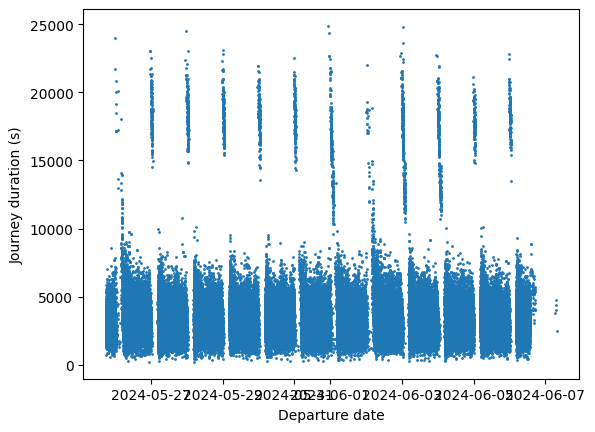

In [11]:
cursor.execute("SELECT * FROM journeys")

# departure datetime is in column 3 (index 2)
# get the departure datetime and duration of each journey
journeys = cursor.fetchall()
departures = [journey[2] for journey in journeys]
durations = [journey[1] for journey in journeys]

# convert the departure datetime to a numerical value
# format: 20240525T175138
# required format: 2024-05-25T17:51:38
import datetime

departures = [datetime.datetime.strptime(departure, '%Y%m%dT%H%M%S') for departure in departures]
# remove outliers
departures_no_outliers = [departure for departure, duration in zip(departures, durations) if duration < q3 + 1.5 * iqr]

# plot the departure datetime vs duration
plt.scatter(departures, durations, s=1)
plt.xlabel('Departure date')
plt.ylabel('Journey duration (s)')
plt.show()
    

### Average duration per day of the week


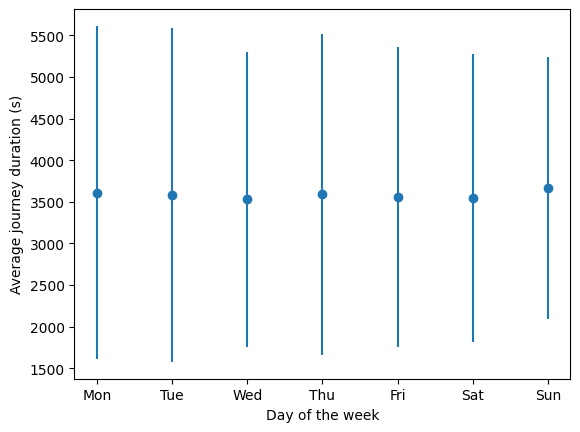

In [12]:
days = [departure.weekday() for departure in departures]
# get the unique days of the week
unique_days = set(days)

# calculate the average duration for each day of the week
average_durations = {}
std_devs = {}
medians = {}
for day in unique_days:
    # get the durations for the current day
    durations_for_day = [duration for duration, current_day in zip(durations, days) if current_day == day]
    
    # calculate the average duration
    average_duration = sum(durations_for_day) / len(durations_for_day)
    average_durations[day] = average_duration
    
    # calculate the standard deviation
    std_dev = (sum([(duration - average_duration) ** 2 for duration in durations_for_day]) / len(durations_for_day)) ** 0.5
    std_devs[day] = std_dev
    
    # calculate the median
    median = sorted(durations_for_day)[len(durations_for_day) // 2]
    medians[day] = median
    
# plot the average duration per day of the week with error bars
plt.errorbar(list(average_durations.keys()), list(average_durations.values()), yerr=list(std_devs.values()), fmt='o')
plt.xticks(list(average_durations.keys()), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Day of the week')
plt.ylabel('Average journey duration (s)')
plt.savefig('out/average_duration_per_day.png')
# plt.close()

Monday and Thursday seem to have the widest error bars while Saturday and Sunday seem to have the smallest.

### Average duration per time of day (morning, afternoon, evening, night)


Text(0, 0.5, 'Median journey duration (s)')

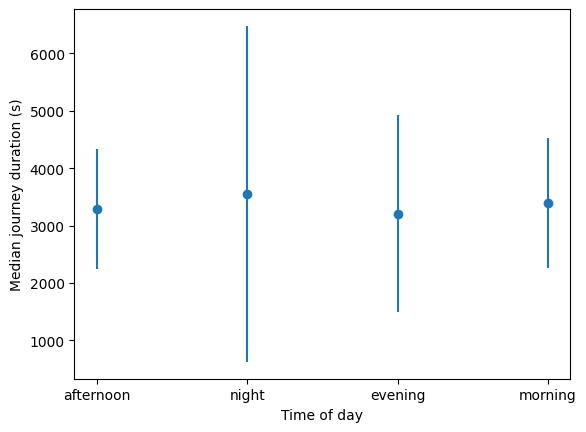

In [13]:
# morning: 6:00 - 12:00
# afternoon: 12:00 - 18:00
# evening: 18:00 - 24:00
# night: 24:00 - 6:00
times_of_day = []
for departure in departures:
    if 6 <= departure.hour < 12:
        times_of_day.append('morning')
    elif 12 <= departure.hour < 18:
        times_of_day.append('afternoon')
    elif 18 <= departure.hour < 24:
        times_of_day.append('evening')
    else:
        times_of_day.append('night')
        
# get the unique times of day
unique_times_of_day = set(times_of_day)

# calculate the average duration for each time of day
average_durations = {}
std_devs = {}
medians = {}

for time_of_day in unique_times_of_day:
    # get the durations for the current time of day
    durations_for_time_of_day = [duration for duration, current_time_of_day in zip(durations, times_of_day) if current_time_of_day == time_of_day]
    
    # calculate the average duration
    average_duration = sum(durations_for_time_of_day) / len(durations_for_time_of_day)
    average_durations[time_of_day] = average_duration
    
    # calculate the standard deviation
    std_dev = (sum([(duration - average_duration) ** 2 for duration in durations_for_time_of_day]) / len(durations_for_time_of_day)) ** 0.5
    std_devs[time_of_day] = std_dev
    
    # calculate the median
    median = sorted(durations_for_time_of_day)[len(durations_for_time_of_day) // 2]
    medians[time_of_day] = median
    
# plot the average duration per time of day in order (morning, afternoon, evening, night) with error bars
plt.errorbar(list(average_durations.keys()), list(average_durations.values()), yerr=list(std_devs.values()), fmt='o')
plt.xlabel('Time of day')
plt.ylabel('Average journey duration (s)')
plt.savefig('out/journeys/average_duration_per_time_of_day.png')
plt.clf()

# do the same with medians
plt.errorbar(list(medians.keys()), list(medians.values()), yerr=list(std_devs.values()), fmt='o')
plt.xlabel('Time of day')
plt.ylabel('Median journey duration (s)')

It seems like the shortest average and median travel times are in the evening and afternoon, while the longest average and median travel time is at night. Night also has the highest margin of error.